In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json

# Deep Neural Networks.

In [2]:
fer = pd.read_csv("../fer2013/fer2013.csv")

In [3]:
fer.pixels = fer.pixels.apply(lambda i: np.fromstring(i, sep=' '))
emotion = {0:'Angry',1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

In [4]:
train = fer[['emotion','pixels']][fer['Usage']=='Training']
public_test = fer[['emotion','pixels']][fer['Usage']=='PublicTest']
private_test = fer[['emotion','pixels']][fer['Usage']=='PrivateTest']

In [5]:
def Xy(xy):
    return np.vstack(xy.pixels.values), np.array(xy.emotion)

In [6]:
X_train,y_train = Xy(train)
X_private_test,y_private_test = Xy(private_test)
X_public_test,y_public_test = Xy(public_test)

In [7]:
def reshape(imgr):
    return imgr.reshape(-1,48,48,1)
X_train = reshape(X_train)
X_public_test = reshape(X_public_test)
X_private_test = reshape(X_private_test)

## Using Keras to build Neural Networks.

In [21]:
from keras.models import Sequential, Model, model_from_json, load_model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras_tqdm import TQDMNotebookCallback

In [22]:
def size_of(i):
    return (i,i)

input_shape = (48, 48, 1)
epochs = 50
batch_size = 256

dropout_rate = 0.25

### A neural network with 6 Convolutions and 4 fully connected layers.

In [23]:
model = Sequential()

model.add(Conv2D(32, 3, strides=size_of(2), activation='relu', data_format="channels_last", input_shape=input_shape))
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=size_of(3), strides=size_of(2)))
model.add(Dropout(dropout_rate))

model.add(Conv2D(64, 2, activation='relu'))
model.add(Conv2D(64, 2, activation='relu'))
model.add(MaxPooling2D(pool_size=size_of(2)))
model.add(Dropout(dropout_rate))

model.add(Conv2D(128, 1, activation='relu'))
model.add(Conv2D(128, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=size_of(2)))
model.add(Dropout(dropout_rate))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(256, activation='relu'))
model.add(Dense(128,  activation='relu'))

model.add(Dense(7,   activation='softmax'))

### Will be saving the best model, stopping if change/learning does not improve after 5 iterations.

In [24]:
# Call backs
# define tqdm callback
tqdmnotebookcallback = TQDMNotebookCallback()
# define a model check point for best model
model_path = "../Models/fer_base_Deep_V2_CNN.h5"
modelcheckpoint = ModelCheckpoint(model_path, monitor='val_acc', save_best_only=True, mode='max', verbose=0)
# define early stopping callback
earlystopping = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=5, mode='max', verbose=0)
# list of callback's
callbacks_list = [tqdmnotebookcallback, earlystopping, modelcheckpoint]

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 23, 23, 32)        320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 9, 9, 64)          8256      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 64)          16448     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)          0         
__________

In [26]:
model_info = model.fit(X_train,
                       to_categorical(y_train),
                       epochs = epochs,
                       batch_size = batch_size, verbose=0,
                       validation_data = (X_private_test, to_categorical(y_private_test)),
                       callbacks = callbacks_list)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [27]:
# serialize model to JSON
best_model = load_model("../Models/fer_base_Deep_V2_CNN.h5")
with open("../Models/fer_base_Deep_V2_CNN.json", "w") as json_file:
    json_file.write(model.to_json())
print("Saved model to disk")

Saved model to disk


In [28]:
public_test_score = best_model.evaluate(X_public_test, to_categorical(y_public_test), verbose=1)

3589/3589 [==============================] - ETA: 20 - ETA: 6 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 467us/step


In [29]:
print(public_test_score)

[1.173784263222355, 0.5533574812008365]


### The above results show the loss, accuracy.

In [30]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.tight_layout()
    plt.show()

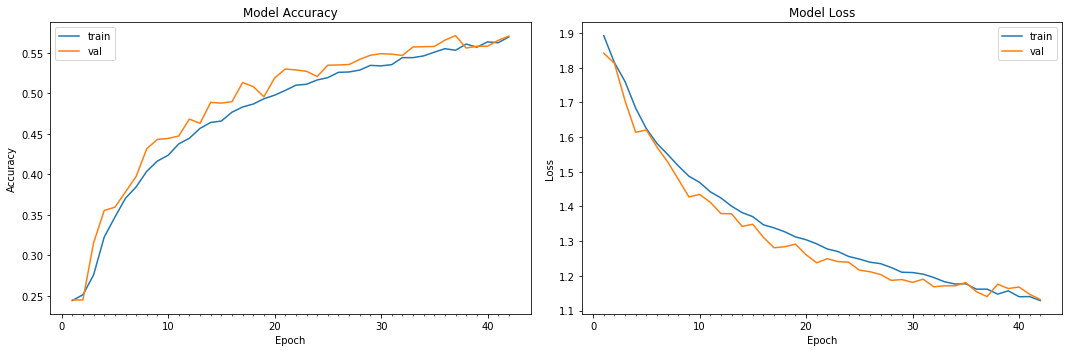

In [31]:
plot_model_history(model_info)

In [32]:
def show_emotion(emo):
    return emotion[np.argmax(emo, axis=None, out=None)]

Originally	 Fear
Predicted as:	 Happy


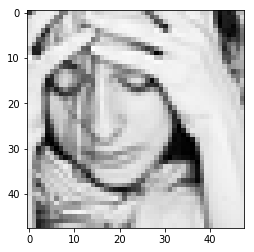

In [33]:
i = 553
plt.imshow(X_public_test[i, :, :, 0], cmap='gray')
print('Originally\t',emotion[y_public_test[i]])
p = model.predict(reshape(X_public_test[i]))
print('Predicted as:\t',show_emotion(p))

## Deep neural network prediction is 55.3%, we will try few more optimization techniques or tune parameters to increase it's accuracy.